# Corregir superposición V2

Esta publicación es una actualización del primer articulo de [Correción de Superposicion](https://chlopezgis.github.io/articulos/python/topologia/superposicion/clean_overlay). Se ha rediseñado la función para mejorar los tiempos del procesamiento

Se requiere tener instalado **`Shapely >= 2.0`** y **`geopandas >= 0.12`**

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd

A continuación, cargaremos la capa de tipo polígono **Sectores**

In [2]:
sectores = gpd.read_file('datos/sectores.shp')

In [3]:
sectores.head()

,id,geometry
0,1,"POLYGON ((-77.07715 -11.94747, -77.07402 -11.9..."
1,2,"POLYGON ((-77.07166 -11.94596, -77.07132 -11.9..."
2,3,"POLYGON ((-77.07695 -11.94743, -77.07589 -11.9..."
3,4,"POLYGON ((-77.07979 -11.95468, -77.07602 -11.9..."
4,5,"POLYGON ((-77.07400 -11.95397, -77.07387 -11.9..."


Vamos a plotear la capa de modo tal que nos permita verifica si esta presenta superposición:

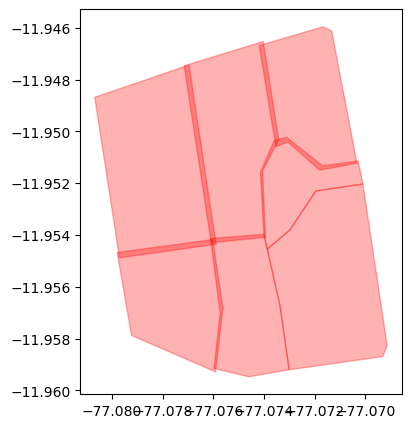

In [4]:
sectores.plot(color='red', alpha=.3, edgecolor='red', figsize= (5,5));

Como se observa en el gráfico, existen varios polígonos que presentan superposición.

A continuación, vamos a crear dos funciones:

* **`diferenceRows`**: Toma 2 geometrias en formato WKT y retorna la diferencia
* **`cleanOverlay`**: Toma como parámetros el **GeoDataFrame** y un **identificador de registro** y retorna un nuevo **GeoDataFrame** con la superposición corregida. Internamente llama a la función **`diferenceRows`**

In [5]:
import shapely.wkt
from shapely.ops import unary_union
import time

def diferenceRows(geomWktA, geomWktB):
    diff = shapely.wkt.loads(geomWktA).difference(unary_union(shapely.wkt.loads(geomWktB)))
    return diff

def cleanOverlay(inGdf, gid):
    # Copiar data:
    gdf = inGdf.copy()
    
    # Crear campo geometria WKT:
    gdf['wkt'] = gdf.geometry.astype(str)
    
    # Identificar polígonos superpuestos por intersección
    gdfInts = gdf.overlay(gdf, how='intersection', keep_geom_type=True)
    # Eliminar duplicados de polígonos superpuestos
    gdfInts = gdfInts.loc[gdfInts[gid+'_1'] < gdfInts[gid+'_2']]
    # Agrupar poligonos para identificar la superposición por cada registro
    gdfOvers = gdfInts.groupby([gid+'_1','wkt_1'])['wkt_2'].agg('unique').reset_index()

    # Identificar geometrias sin superposición
    gdfNotOvers = gdf[~gdf[gid].isin(list(gdfOvers[gid+'_1']))]
    
    # Deupurar la superposición de poligonos
    gdfOversClean = gpd.GeoDataFrame(gdfOvers, geometry=None) # Convertir df a gdf
    # Invocando a la funcion "differenceRows"
    start = time.time()
    gdfOversClean['geometry'] = gdfOversClean.apply(lambda row: diferenceRows(row['wkt_1'], 
                                                                              row['wkt_2']),
                                                    axis=1)
    end = time.time()
    print(f'Tiempo para realizar la corrección: {end-start}')
    # Actualizar crs de "gdfOvers"
    gdfOversClean.set_crs(gdfNotOvers.crs, inplace=True)
    # Renombrar campos
    gdfOversClean = gdfOversClean.rename(columns={gid+'_1':gid})
    # Retorno
    return pd.concat([gdfOversClean[[gid,'geometry']],gdfNotOvers[[gid,'geometry']]])

Ejecutando la función

In [6]:
start = time.time()

# Ejecuón de funcion
sectoresClean = cleanOverlay(sectores, 'id')

end = time.time()
print(f'Tiempo de todo el proceso: {end-start}')

Tiempo para realizar la corrección: 0.008028030395507812
Tiempo de todo el proceso: 0.11079764366149902


**Comparemos los tiempos con la anterior función que realizaba la corrección**:

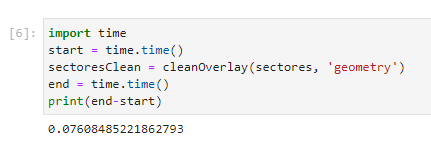

* Vemos que la nueva función es 10 veces más rápido que la anterior función. Sin embargo, se demora un poco mas en todo el procesamiento al realizar diferentes operaciones de preparación de la data.

Visualaremos el resultado

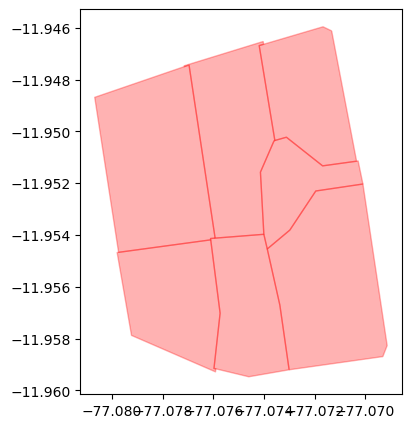

In [7]:
sectoresClean.plot(color='red', alpha=.3, edgecolor='red', figsize= (5,5));

Antes de exportar los datos visualizemos los tipos de geometría:

In [8]:
sectoresClean.geometry.geom_type.value_counts()

Polygon    7
dtype: int64

Como se observan todos son de tipo poligono, asi que no realizaremos ningun proceso de homologación de geometrias.

Finalmente, exportaremos la nueva capa como shapefile

In [9]:
sectoresClean.to_file('datos/SectoresClean.shp')

## **Reutilizando la funcion**

Reutilizaremos la función para corregir la superposición de una capa de Zonas Catastrales que contiene un mayor volumen de registros: 857

In [10]:
zonas = gpd.read_file('datos/zonas.shp')

In [11]:
zonas.shape

(857, 7)

Visualizaremos los atributos

In [12]:
zonas.head()

,OBJECTID,ID_DIST,COD_ZONA,ID_ZONA,SHAPE.AREA,SHAPE.LEN,geometry
0,1,200605,99,20060599,0.0,0.0,"POLYGON ((-80.76846 -4.84790, -80.76869 -4.847..."
1,2,200401,06,20040106,0.0,0.0,"POLYGON ((-80.16641 -5.09945, -80.16684 -5.100..."
2,3,140113,05,14011305,0.0,0.0,"POLYGON ((-79.81545 -6.88408, -79.81983 -6.891..."
3,4,200104,15,20010415,0.0,0.0,"POLYGON ((-80.62272 -5.21333, -80.62684 -5.220..."
4,5,200104,03,20010403,0.0,0.0,"POLYGON ((-80.60302 -5.18579, -80.60187 -5.189..."


Reutilizando la función:

In [13]:
start = time.time()

# Ejecuón de funcion
zonasClean = cleanOverlay(zonas, 'OBJECTID')

end = time.time()
print(f'Tiempo de todo el proceso: {end-start}')

Tiempo para realizar la corrección: 0.12502741813659668
Tiempo de todo el proceso: 1.575824499130249


**Comparemos los tiempos con la anterior función**:

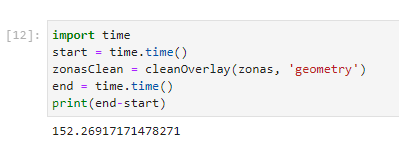

Y es aquí donde se observa la mejora en el rendimiento, el proceso de corrección es mas de 1200 veces mas rápido, mientras que todo el proceso es 100 veces mas rápido

Verificando los tipos de geometría:

In [14]:
zonasClean.geometry.geom_type.value_counts()

Polygon         856
MultiPolygon      1
dtype: int64

Como se observa existe un geometria de tipo **"GeometryCollection"**, para quedarnos con geometrias de tipo poligonal, vamos a realizar un **explode** y luego eliminar las geometrias que nos sean polígonos:

In [15]:
# Explotando la geometria
zonasClean = zonasClean.explode(ignore_index=True, index_parts=True)

In [16]:
zonasClean.head()

,OBJECTID,geometry
0,5,"POLYGON ((-80.60187 -5.18980, -80.60803 -5.191..."
1,9,"POLYGON ((-80.67911 -3.68414, -80.67918 -3.684..."
2,10,"POLYGON ((-80.73793 -3.71627, -80.73986 -3.715..."
3,13,"POLYGON ((-80.67413 -3.68262, -80.67447 -3.681..."
4,17,"POLYGON ((-79.46737 -7.24525, -79.46914 -7.248..."


Verificamos nuevamente el tipo de geometría:

In [17]:
zonasClean.geometry.geom_type.value_counts()

Polygon    858
dtype: int64

Exportar capa:

In [ ]:
zonasClean.to_file('datos/zonas_clean.shp')

**DISCLAIMER**

Este script se ha elaborado en base a experiencia propia, por lo cual, probablemente se requiera adaptar y optimizar para su reutilización. Además, se requiere de mayor casos de uso para identificar bugs en su ejecución.

Por tal motivo, la finalidad de esta publicación es mostrar las potencialidades de python para el manejo de datos espaciales.

* **Elaborado por:** Charlie Lopez Rengifo
* **email:** chlopezgis@gmail.com
* **[Linkedin](https://www.linkedin.com/in/chlopezgis/)**
* **[GitHub](https://github.com/chlopezgis/)**